## Analysis of short-reads scRNA-seq (immune component)

This notebook is a second-pass analysis of immune component of the sample.

**Inputs and Outputs**
- Inputs:
  - `raw_feature_bc_matrix.h5`: raw counts from 10x cellranger counts pipeline
  - `M132TS_immune_barcodes.npy`: list of immune cell barcodes for the sample
- Outputs:
  - `M132TS_immune.hd5ad`: an AnnData object object containing filtered cells (immune)  

In [1]:
%matplotlib inline

import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import os
import sys
from time import time
import logging
import pickle

import scanpy as sc

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
sc.__version__

'1.7.2'

In [3]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'

m132ts_h5_path = 'data/t-cell-vdj/M132TS/raw_feature_bc_matrix.h5'
barcode_path = 'output/t-cell-vdj-cite-seq/M132TS_immune_barcodes.npy'
m132ts_h5ad_out_path = 'output/t-cell-vdj-cite-seq/M132TS_immune.h5ad'
m132ts_h5_full_path = os.path.join(repo_root, m132ts_h5_path)
m132ts_h5ad_out_full_path = os.path.join(repo_root, m132ts_h5ad_out_path)
barcode_full_path = os.path.join(repo_root, barcode_path)

h5_full_path = m132ts_h5_full_path
h5ad_out_full_path = m132ts_h5ad_out_full_path

In [4]:
adata = sc.read_10x_h5(h5_full_path, gex_only=False)
adata.var_names_make_unique()
barcodes = np.load(barcode_full_path, allow_pickle=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# remove '-1' suffixed from barcodes
def remove_barcode_suffix(barcode: str, delimiter='-') -> str:
    return barcode.split(delimiter)[0]
adata.obs.index = np.asarray(list(map(remove_barcode_suffix, adata.obs.index.values)))

In [6]:
# subset adata to the specified barcodes
barcodes_set = set(barcodes)
adata_barcode_keep_indices = [
    idx for idx in range(len(adata))
    if adata.obs.index.values[idx] in barcodes_set]
adata = adata[adata_barcode_keep_indices]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 6332 × 36605
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['antibody_feature'] = (adata.var.feature_types == 'Antibody Capture')

# add log(1 + antibody counts) as 'obs' annotations for each cell
adata_ab = adata[:, adata.var['antibody_feature']]
ab_list = list(adata_ab.var.index.values)
for ab_idx, ab in enumerate(ab_list):
    adata.obs[ab] = \
        np.log1p(np.asarray(adata_ab.X[:, ab_idx].todense()).squeeze())
    
# remove antibody counts from variables
adata = adata[:, ~adata.var['antibody_feature']]

Trying to set attribute `.var` of view, copying.


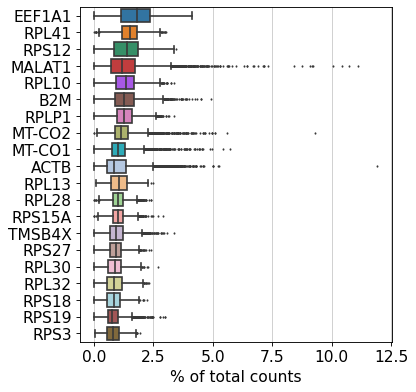

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [10]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata

AnnData object with n_obs × n_vars = 6332 × 36601
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
sc.pp.filter_genes(adata, min_cells=3)

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


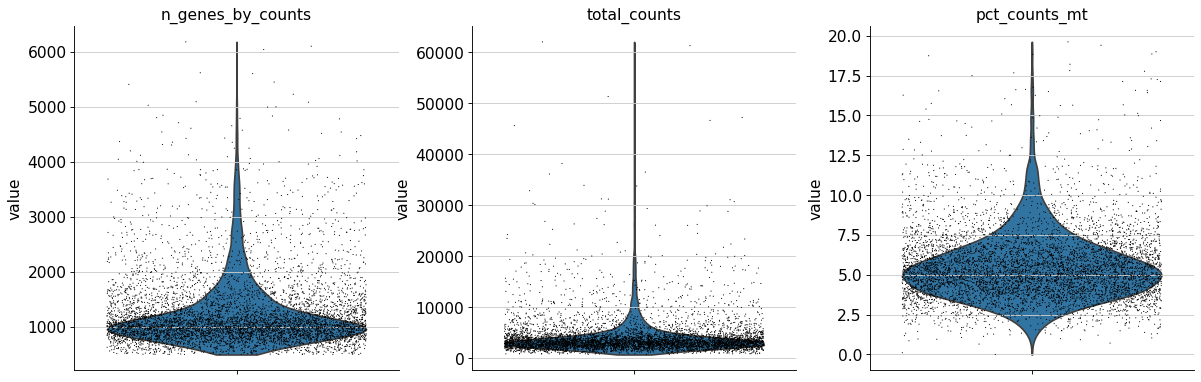

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

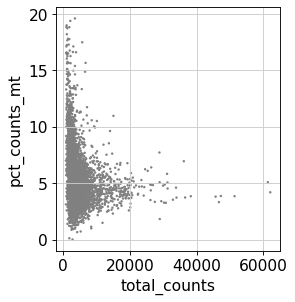

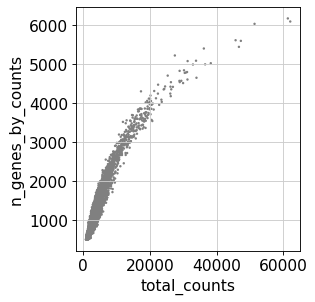

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [16]:
adata.raw = adata

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [18]:
sc.pp.log1p(adata)

## A first look at clustering (based on log-normalized counts)

Note: Our final clustering and analysis will be based on Seurat's SCT counts.

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.5)

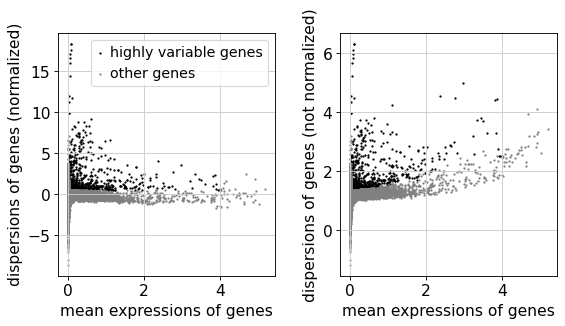

In [20]:
sc.pl.highly_variable_genes(adata)

In [21]:
# keep genes that are highly variable
adata = adata[:, adata.var.highly_variable]

In [22]:
sc.pp.scale(adata, max_value=10)

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

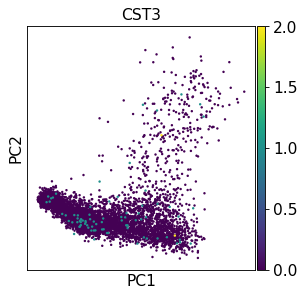

In [24]:
sc.pl.pca(adata, color='CST3')

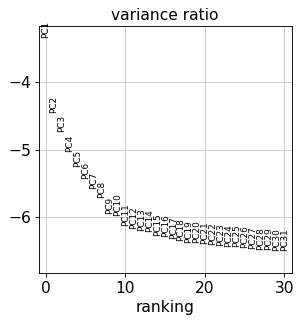

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata

AnnData object with n_obs × n_vars = 6332 × 1532
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [28]:
sc.tl.tsne(adata)

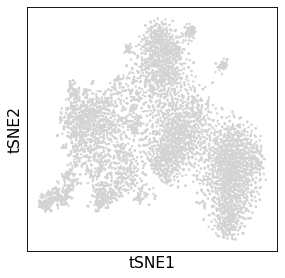

In [29]:
sc.pl.tsne(adata)

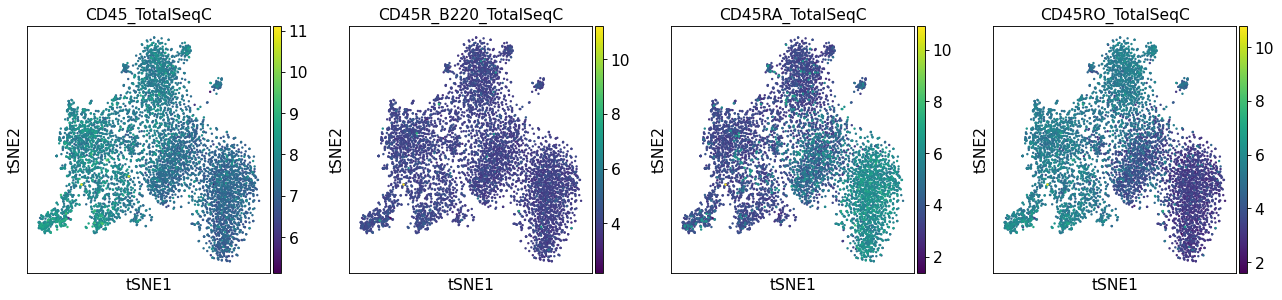

In [30]:
sc.pl.tsne(adata, color=['CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC'])

Text(0, 0.5, 'CD45 AB (log)')

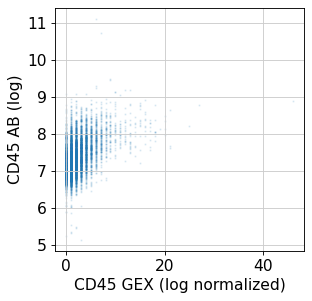

In [31]:
# make a scatter plot of CD45 GEX vs. AB
CD45_gex = np.asarray(adata.raw.X[:, adata.raw.var.index.values == 'PTPRC'].todense()).flatten()
CD45_ab = adata.obs['CD45_TotalSeqC'].values.flatten()
plt.scatter(CD45_gex, CD45_ab, s=1, alpha=0.1)
plt.xlabel('CD45 GEX (log normalized)')
plt.ylabel('CD45 AB (log)')

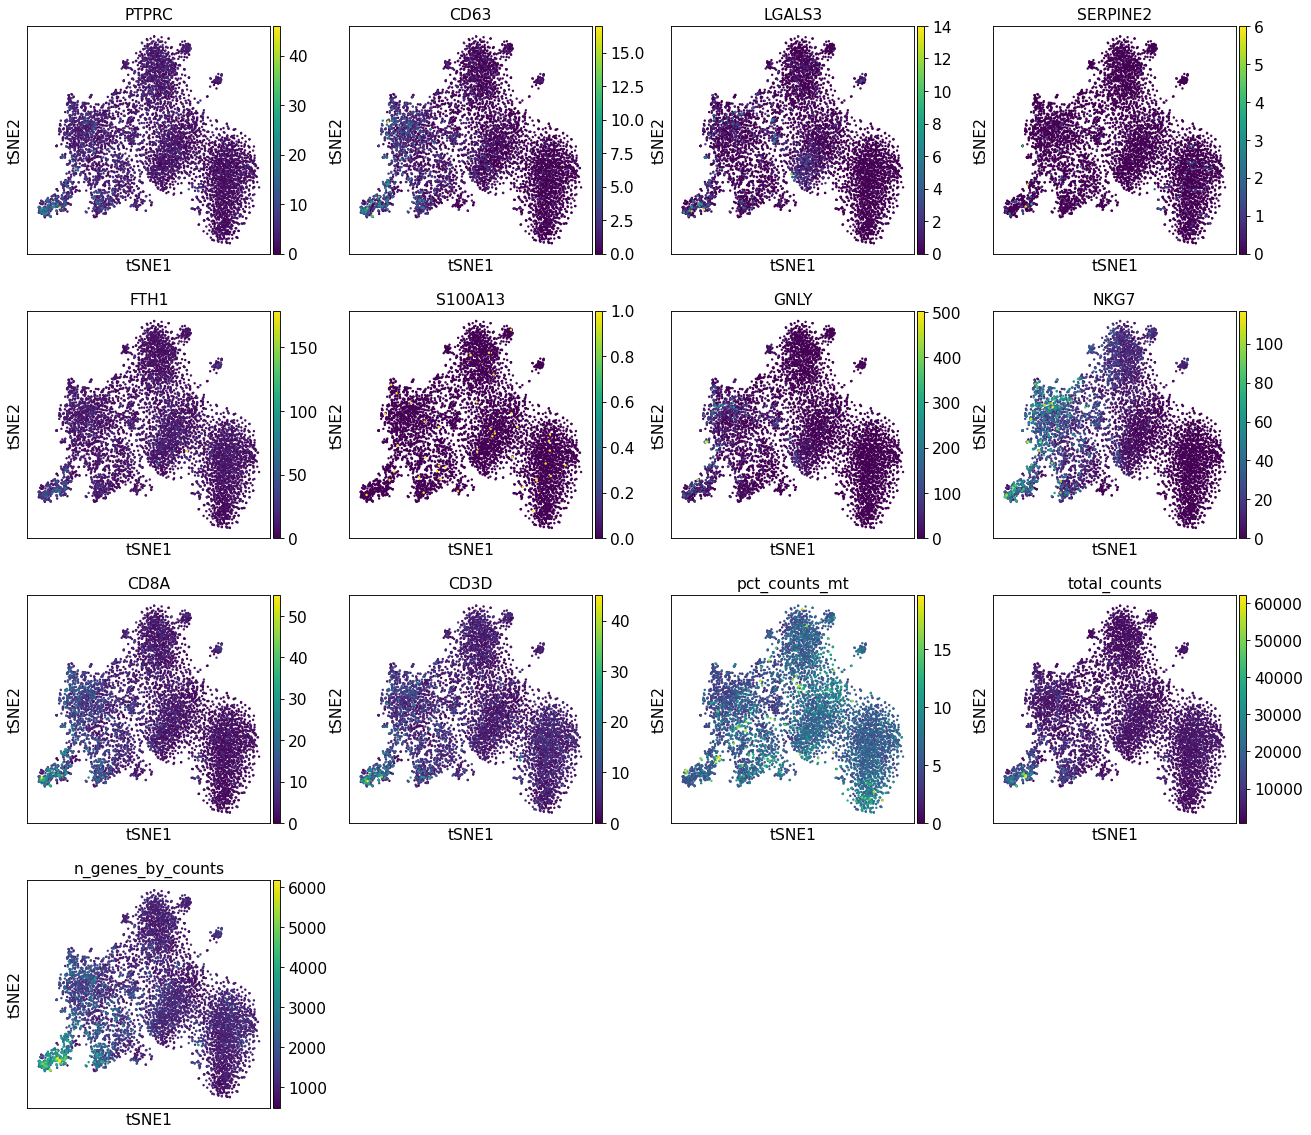

In [32]:
sc.pl.tsne(
    adata,
    color=['PTPRC', 'CD63', 'LGALS3', 'SERPINE2', 'FTH1', 'S100A13', 'GNLY', 'NKG7', 'CD8A', 'CD3D',
            'pct_counts_mt', 'total_counts', 'n_genes_by_counts'])

In [33]:
sc.tl.leiden(adata, resolution=1.0)

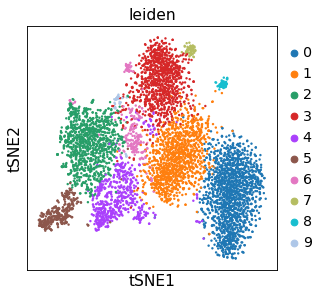

In [34]:
sc.pl.tsne(adata, color=['leiden'])

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

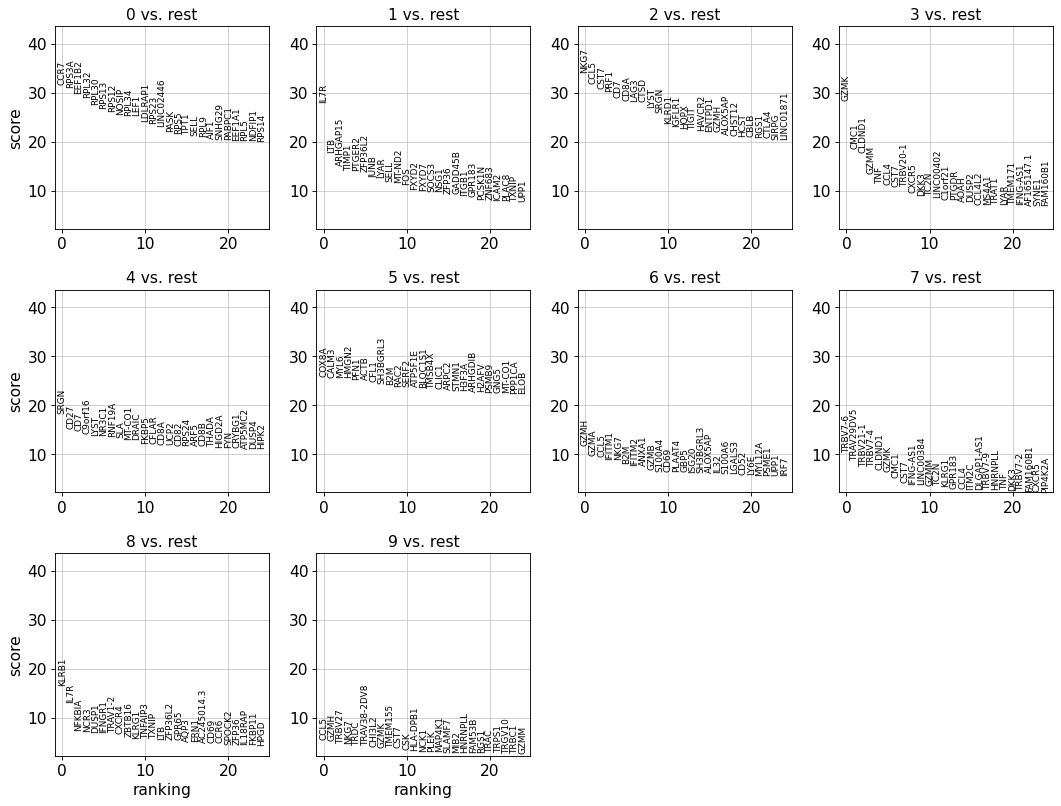

In [36]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=True)

In [37]:
adata

AnnData object with n_obs × n_vars = 6332 × 1532
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals', 'pvals_adj']})

In [39]:
result_df

,0_names,0_pvals,0_pvals_adj,1_names,1_pvals,1_pvals_adj,2_names,2_pvals,2_pvals_adj,3_names,...,6_pvals_adj,7_names,7_pvals,7_pvals_adj,8_names,8_pvals,8_pvals_adj,9_names,9_pvals,9_pvals_adj
0,CCR7,6.612364e-180,1.322473e-177,IL7R,8.173675e-140,1.018566e-136,NKG7,9.688379e-181,5.231725e-177,GZMK,...,1.599014e-23,TRBV7-6,7.048162e-16,5.345516e-15,KLRB1,4.160125e-25,7.632393e-24,CCL5,3.646062e-06,1.317560e-05
1,RPS3A,3.958370e-192,9.865475e-190,LTB,1.792256e-64,1.792256e-62,CCL5,7.861163e-162,1.819298e-158,CMC1,...,3.144187e-17,TRAV29DV5,5.902485e-13,3.741012e-12,IL7R,8.477658e-20,1.120213e-18,GZMH,4.727998e-06,1.672714e-05
2,EEF1B2,4.255662e-175,8.016479e-173,ARHGAP15,1.032327e-47,4.724210e-46,CST7,5.686861e-158,1.151589e-154,CLDND1,...,1.085898e-16,TRBV21-1,1.750149e-10,9.199356e-10,NFKBIA,5.463885e-10,3.825192e-09,TRBV27,4.701742e-05,1.525195e-04
3,RPL32,3.141897e-167,5.472982e-165,TIMP1,8.722879e-43,3.293954e-41,PRF1,1.530807e-151,2.066589e-148,GZMM,...,5.717129e-15,TRBV7-4,1.858288e-10,9.751947e-10,NCR3,1.168597e-09,7.901199e-09,NKG7,5.173331e-05,1.675824e-04
4,RPL30,8.159530e-153,1.040822e-150,PTGER2,2.205457e-42,8.138589e-41,CD7,8.395136e-146,9.714372e-143,TNF,...,5.039353e-15,CLDND1,1.950374e-09,9.392409e-09,DUSP1,1.519894e-09,1.025501e-08,TRDC,1.004219e-04,3.156450e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,FYN,0.000000e+00,0.000000e+00,SRGN,1.071908e-163,3.472981e-160,PASK,9.474972e-170,2.558242e-166,RPL22,...,4.274325e-51,CTLA4,5.170814e-205,2.094180e-201,EIPR1,7.333353e-133,2.970008e-129,SDF2,3.303413e-162,1.070306e-158
16196,B2M,0.000000e+00,0.000000e+00,ENTPD1,4.784507e-166,1.937725e-162,RPS12,2.375252e-171,7.695817e-168,RPS13,...,1.055610e-51,MAL,3.561228e-217,1.923063e-213,CD38,3.853375e-133,2.080822e-129,CFAP97,7.408803e-163,3.000565e-159
16197,NKG7,0.000000e+00,0.000000e+00,LYST,5.202868e-204,2.809549e-200,SELL,1.323197e-180,5.358946e-177,NOSIP,...,1.198759e-56,LEF1,6.214800e-224,5.033988e-220,ZNF580,3.364236e-148,2.725031e-144,AC100810.1,4.560701e-166,2.462779e-162
16198,CCL5,0.000000e+00,0.000000e+00,NKG7,1.132147e-243,9.170389e-240,EEF1B2,1.741296e-220,1.410450e-216,LINC02446,...,9.796982e-87,LINC02446,5.096346e-163,1.179440e-159,COTL1,1.007523e-124,2.331695e-121,SMIM10L1,1.123598e-205,9.101141e-202


In [40]:
adata.write(h5ad_out_full_path)